In [1]:
from speedup import generate_psf, generate_out_images, solve_inverse_implicit, recovery_quality
import imageio
from scipy.signal import convolve
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def richardson_lucy_deconvolution(k, o, h, i):
    for j in range(k):
        o = convolve(i / convolve(o, h, mode = 'same'), np.flip(h), mode = 'same') * o
    return o

In [3]:
def blind_richardson_lucy_deconvolution(k, o, h, i):
    l1 = (h.shape[2] - o.shape[2]) // 2
    l2 = l1 + o.shape[2]
    for j in range(k):
        h = convolve(i / convolve(h, o, mode = 'same'), np.flip(o), mode = 'same') * h
        o = convolve(i[:, :, l1:l2] / convolve(o, h, mode = 'same'), np.flip(h), mode = 'same') * o
    return o, h

In [4]:
dim = 512
m = 3
w = 0.1
stationary_defocus = 0.05

In [5]:
h = generate_psf(dim, m, w, stationary_defocus)

## Наблюдаемые изображения

In [6]:
src1 = imageio.imread('images/1.png')
src2 = imageio.imread('images/2.png')
src3 = imageio.imread('images/3.png')

src = np.zeros((dim, dim, m), np.double)
src[:, :, 0] = src1[:, :, 0]
src[:, :, 1] = src2[:, :, 0]
src[:, :, 2] = src3[:, :, 0]
src = src / np.amax(src)

generated_images = convolve(src, h, mode = 'same')
generated_images = generated_images / np.amax(generated_images)

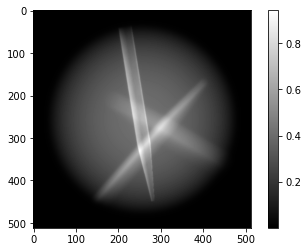

In [7]:
plt.imshow(generated_images[:, :, 0], cmap="gist_gray")
plt.colorbar()
#plt.savefig('i.png')

## Применение итерационного метода в спектральной области для синтетических данных

In [8]:
%%time
o = solve_inverse_implicit(generated_images, dim, m, w, stationary_defocus, 1, 3)
o = o / np.amax(o)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


Wall time: 2min 49s


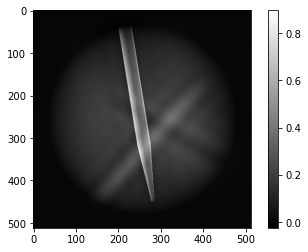

In [9]:
plt.imshow(o[:dim, :dim, 0], cmap="gist_gray")
plt.colorbar()
#plt.savefig('recovered 1.png')

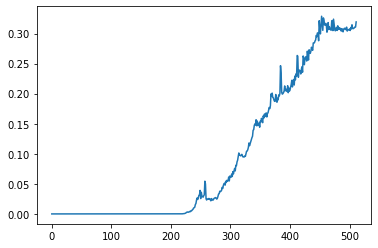

In [10]:
x_plot, y_plot = recovery_quality(src[:,:,0], o[:,:,0], dim)
plt.plot(x_plot, y_plot)
#plt.savefig('vfc 1.png')

## Применение алгоритма Ричардсона-Люси для синтетических данных

In [11]:
%%time
res1 = richardson_lucy_deconvolution(100, np.ones((512, 512, 3)), h, generated_images)
res1 = res1 / np.amax(res1)

Wall time: 8min 51s


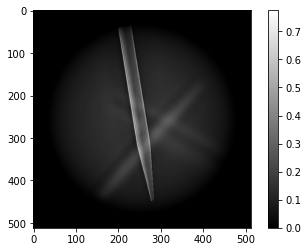

In [12]:
plt.imshow(res1[:, :, 0], cmap="gist_gray")
plt.colorbar()
#plt.savefig('recovered 2.png')

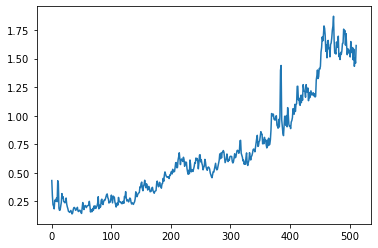

In [13]:
ext_res1 = np.zeros((dim * 2 - 1, dim * 2 - 1))
ext_res1[:dim,:dim] = res1[:,:,0]
x_plot, y_plot = recovery_quality(src[:,:,0], ext_res1, dim)
plt.plot(x_plot, y_plot)
#plt.savefig('vfc 2.png')

## Применение слепой деконволюции алгоритма Ричардсона-Люси для синтетических данных

In [14]:
%%time
generated_images_ext = convolve(h, src, mode = 'same')
res2, new_h = blind_richardson_lucy_deconvolution(25, np.ones((512, 512, 3)), h, generated_images_ext)
res2 = res2 / np.amax(res2)

Wall time: 4min 28s


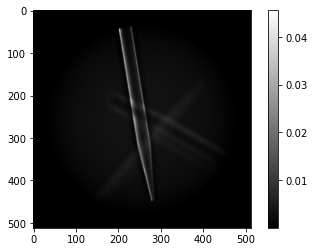

In [15]:
plt.imshow(res2[:, :, 0], cmap="gist_gray")
plt.colorbar()
#plt.savefig('recovered 3.png')

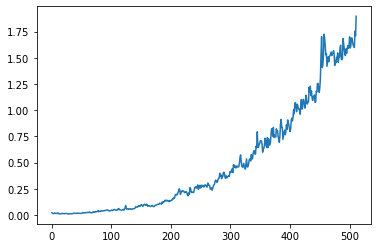

In [16]:
ext_res2 = np.zeros((dim * 2 - 1, dim * 2 - 1))
ext_res2[:dim,:dim] = res2[:,:,0]
x_plot, y_plot = recovery_quality(src[:,:,0], ext_res2, dim)
plt.plot(x_plot, y_plot)
#plt.savefig('vfc 3.png')

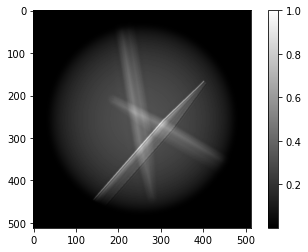

In [17]:
plt.imshow(res2[:, :, 1], cmap="gist_gray")
plt.colorbar()
#plt.savefig('recovered 3.png')